# Huggingface Fine Tuning

## Overview

Step by step Hugginface fine tuning with DistilBert.

## Dependency

Using the data for [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data). Download **jigsaw-toxic-comment-classification-challenge.zip** and place it in the directory pointed by the **DATA_DIR** variable.

## References

* [A Visual Guide to Using BERT for the First Time](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

* [Hugging Face Transformers: Fine-tuning DistilBERT for Binary Classification Tasks](https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379)

* [Training TFBertForSequenceClassification with custom X and Y data](https://stackoverflow.com/a/63295240/4281353)

---
# Setups

In [1]:
import os
import sys
import gc
import re
import string
import datetime
import logging
from pathlib import Path

## Constants

In [2]:
# To reduce the data volumen to run through the training in short timeframe.
TEST_MODE = True

## Execution recording (e.g. 2021JUL012322)
#TIMESTAMP = datetime.datetime.now().strftime("%Y%b%d%H%M").upper()
TIMESTAMP = input("Enter TIMESTAMP e.g. 2021JUL012322 to identify this execution.") 
print(f"Execution timestamp {TIMESTAMP}")

# Directory to manage the data. 
# Place jigsaw-toxic-comment-classification-challenge.zip in DATA_DIR
DATA_DIR = "."
OUTPUT_DIR = "."

# Flag to overwrite the cleaned data
FORCE_OVERWRITE = False

# Labbels that classifies the type of the comment.
CATEGORIES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

Enter TIMESTAMP e.g. 2021JUL012322 to identify this execution.HOGE
Execution timestamp HOGE


## Environment Specifics
### Google Colab

Google Colab specific operations.

In [3]:
def google_colab_info():
    """Information on the Google Colab environment
    """
    # --------------------------------------------------------------------------------
    # GPU
    # --------------------------------------------------------------------------------
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)

    # --------------------------------------------------------------------------------
    # Memory
    # --------------------------------------------------------------------------------
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
        print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
        print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
        print('re-execute this cell.')
    else:
        print('You are using a high-RAM runtime!')

In [4]:
try:
    # --------------------------------------------------------------------------------
    # Check if the environment is Google Colab.
    # --------------------------------------------------------------------------------
    import google.colab
    IN_GOOGLE_COLAB = True
    print("Using Google Colab environment.")

    # --------------------------------------------------------------------------------
    # Show Google Colab information
    # --------------------------------------------------------------------------------
    google_colab_info()

    # --------------------------------------------------------------------------------
    # Mount Google drive
    # --------------------------------------------------------------------------------
    google.colab.drive.mount('/content/drive', force_remount=True)
    
    # --------------------------------------------------------------------------------
    # Directory to manage the data
    # --------------------------------------------------------------------------------
    DATA_DIR = "/content/drive/MyDrive/kaggle/toxic_comment_classification"
    PICKLE_DIR = DATA_DIR
    OUTPUT_DIR = DATA_DIR

    # --------------------------------------------------------------------------------
    # GPU Optimized modules
    # --------------------------------------------------------------------------------
    !pip install -U spacy[cuda102]
    !python -m spacy download en_core_web_sm
    
except ModuleNotFoundError as e:
    # if str(e) == "No module named 'google.colab'":
    IN_GOOGLE_COLAB = False    
    print("Not using Google Colab environment.")

except ValueError as e:
    # https://stackoverflow.com/a/68203799/4281353
    print(f"{str(e)}: possible known issue https://stackoverflow.com/a/68203799/4281353")
    if os.path.isdir('/content/drive'):
        !ls -lrt /content/drive
        # !rm -rf /content/drive
        # google.colab.drive.flush_and_unmount()
    raise e
    

Using Google Colab environment.
Sun Jul  4 03:13:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                        

### Kaggle
* [How to detect the environment that I'm running the notebook](https://www.kaggle.com/getting-started/147177)

In [5]:
import os
print(f"os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') == '{os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost')}'")

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE',''):
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')                         | We are running a Kaggle Notebook/Script - Could be Interactive or Batch Mode")  
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'        | We are running a Kaggle Notebook/Script - Interactive Mode")
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch'              | We are running a Kaggle Notebook/Script - Batch Mode")
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == '':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == ''                   | We are running code on Localhost")    
    IN_KAGGLE = False

if IN_KAGGLE:
    # --------------------------------------------------------------------------------
    # Directory to manage the data
    # --------------------------------------------------------------------------------
    DATA_DIR = "/kaggle/input/jigsaw-toxic-comment-classification-challenge"
    PICKLE_DIR = "/kaggle/working"
    OUTPUT_DIR = "/kaggle/working"

    # --------------------------------------------------------------------------------
    # GPU Optimized modules
    # --------------------------------------------------------------------------------
    !pip install -U spacy[cuda102]
    !python -m spacy download en_core_web_sm

os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') == 'Localhost'
os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == ''                   | We are running code on Localhost


### Localhost

In [6]:
if (not IN_GOOGLE_COLAB) and (not IN_KAGGLE):
    !pip install h5py pandas matplotlib 
    !pip install -U spacy
    !python -m spacy download en_core_web_sm
    !python -m spacy validate

## Modules

Install and load Python modules required for the task.

In [7]:
!pip install -U setuptools wheel
!pip install -U transformers clean_text
!pip install -U line_profiler memory_profiler

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (57.0.0)
Requirement already up-to-date: wheel in /usr/local/lib/python3.7/dist-packages (0.36.2)
Requirement already up-to-date: transformers in /usr/local/lib/python3.7/dist-packages (4.8.2)
Requirement already up-to-date: clean_text in /usr/local/lib/python3.7/dist-packages (0.4.0)
Requirement already up-to-date: line_profiler in /usr/local/lib/python3.7/dist-packages (3.3.0)
Requirement already up-to-date: memory_profiler in /usr/local/lib/python3.7/dist-packages (0.58.0)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Logging

Control the logging outputs to supress the warning and information to prevent the execution results from being cluttered. 

In [9]:
logging.disable(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

## Utilities


## Jupyter Notebook

Jupyter cell format configurations. Align the cell output to the left.

In [10]:
%%html
<style>
table {float:left}
</style>

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=1000) 

## Pandas

In [11]:
import pandas as pd
pd.options.display.max_colwidth = 1000   # Allow long string content in a cell

## TensorFlow

Control TensorFlow logging.

| TF_CPP_MIN_LOG_LEVEL | Description|          
| - |------------- | 
|0| Suppress all messages are logged (default behavior)|
|1 |Suppress INFO messages are not printed|
|2 |Suppress INFO and WARNING messages are not printed|
|3 |Suppress INFO, WARNING, and ERROR messages are not printed|



In [12]:
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Transformers

[HuggingFace](https://huggingface.co/transformers/) offers the libarary for NLP (Natural Language Processing) based on the Transfoemer architecture introduced in the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Google.

> Transformers provides general-purpose architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between Jax, PyTorch and TensorFlow.

### Transfer Learning (Fine-Tuning)

Utilize the [Sequence Classification](https://huggingface.co/transformers/task_summary.html#sequence-classification) capabilty of BERT for the text classification by fine-tuing the pre-trained BERT model upon the data provided. 

* [Fine-tuning a pretrained model](https://huggingface.co/transformers/training.html)
> How to fine-tune a pretrained model from the Transformers library. In TensorFlow, models can be directly trained using Keras and the fit method. 

* [Fine-tuning with custom datasets](https://huggingface.co/transformers/custom_datasets.html)
> This tutorial will take you through several examples of using 🤗 Transformers models with your own datasets.

* [HuggingFace Text classification examples](https://github.com/huggingface/transformers/tree/master/examples/tensorflow/text-classification)
> This folder contains some scripts showing examples of text classification with the hugs Transformers library. 

The code in this notebook is based on the [run_text_classification.py](https://github.com/huggingface/transformers/blob/master/examples/tensorflow/text-classification/run_text_classification.py) example for TensorFlow and the code in the documentation [Fine-tuning with custom datasets](https://huggingface.co/transformers/custom_datasets.html).

In [13]:
from transformers import (
    PreTrainedModel,
    DistilBertTokenizerFast,
    TFDistilBertForSequenceClassification,
    TFTrainer,
    TFTrainingArguments
)

# --------------------------------------------------------------------------------
# Control log level (https://huggingface.co/transformers/main_classes/logging.html)
# --------------------------------------------------------------------------------
os.environ['TRANSFORMERS_VERBOSITY'] = "error"
import transformers
transformers.logging.set_verbosity(transformers.logging.ERROR)

## Output Directories

In [14]:
# Result output directory
RESULT_DIRECTORY = f"{OUTPUT_DIR}/toxicity_classification_{TIMESTAMP}"
Path(RESULT_DIRECTORY).mkdir(parents=True, exist_ok=True)

if not os.access(RESULT_DIRECTORY, os.W_OK):
    raise RuntimeError(f"{RESULT_DIRECTORY} not writable")
if not os.access(PICKLE_DIR, os.W_OK):
    raise RuntimeError(f"{PICKLE_DIR} not writable")

MODEL_DIRECTORY = "{parent}/model".format(
    parent=RESULT_DIRECTORY
)
Path(MODEL_DIRECTORY).mkdir(parents=True, exist_ok=True)

LOG_DIRECTORY = "{parent}/log".format(
    parent=RESULT_DIRECTORY,
)
Path(LOG_DIRECTORY).mkdir(parents=True, exist_ok=True)

---
# Ingenstion



## Data
### DATA_PATH
**DATA_PATH** variable points to the location of the data package for [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data) in the Google Drive or in the local directory. Unzip the data package to extract the data for training and testing.

* train.csv
* test.csv
* test_labels.csv - 0/1 binary labels to identify the comment is rated for each category (e.g. toxici).

In [15]:
if IN_GOOGLE_COLAB:
    DATA_PATH=f"{DATA_DIR}/jigsaw-toxic-comment-classification-challenge.zip"
elif IN_KAGGLE:
    pass
else:
    DATA_PATH = input("Enter the data archive path") 

In [16]:
if not IN_KAGGLE:
    !unzip -o $DATA_PATH -d $DATA_DIR || echo

!unzip -o $DATA_DIR/train.csv.zip -d .
!unzip -o $DATA_DIR/test.csv.zip -d .
!unzip -o $DATA_DIR/test_labels.csv.zip -d .

Archive:  /content/drive/MyDrive/kaggle/toxic_comment_classification/jigsaw-toxic-comment-classification-challenge.zip
  inflating: /content/drive/MyDrive/kaggle/toxic_comment_classification/sample_submission.csv.zip  
  inflating: /content/drive/MyDrive/kaggle/toxic_comment_classification/test.csv.zip  
  inflating: /content/drive/MyDrive/kaggle/toxic_comment_classification/test_labels.csv.zip  
  inflating: /content/drive/MyDrive/kaggle/toxic_comment_classification/train.csv.zip  
Archive:  /content/drive/MyDrive/kaggle/toxic_comment_classification/train.csv.zip
  inflating: ./train.csv             
Archive:  /content/drive/MyDrive/kaggle/toxic_comment_classification/test.csv.zip
  inflating: ./test.csv              
Archive:  /content/drive/MyDrive/kaggle/toxic_comment_classification/test_labels.csv.zip
  inflating: ./test_labels.csv       


## Raw Dataframes

Load the original data from the CSV files into ```raw_``` dataframes.

* raw_train is from train.csv
* raw_test is merged from test.csv and test_labels.csv

In [17]:
raw_train = pd.read_csv("./train.csv")
raw_test_data = pd.read_csv("./test.csv")
raw_test_label = pd.read_csv("./test_labels.csv")
raw_test = pd.merge(raw_test_data, raw_test_label, left_on='id', right_on='id', how='inner')

if TEST_MODE:
    raw_train = raw_train.head(64)
    raw_test = raw_test.head(32)

### Raw data (train.csv)

In [18]:
# If in Google colab runtime and got an error, restart the runtime.
# "AttributeError: 'NotebookFormatter' object has no attribute 'get_result'""
# https://stackoverflow.com/questions/66412776
raw_train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0


In [19]:
raw_train[raw_train['toxic'] > 0].head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1,0,0,0,0,0


### Raw data (test.csv)
Remove the rows where the label value is -1 as as the meaning is not clearly defined.

> test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring

In [20]:
raw_test[(raw_test['toxic'] >= 0)].head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beckett infobox? And why do you bother bringing up the long-dead completely non-existent """"Influences"""" issue? You're just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories! \n\n """,0,0,0,0,0,0


In [21]:
# Keep the raw non-mutated whereas train/test are mutated.
train = raw_train.copy()
test = raw_test[(raw_test['toxic'] >= 0)].copy()
if test['id'].count() >= train['id'].count():
    raise RuntimeError("Invalid counts. Verfity the train/test data.")
del raw_train, raw_test
    
gc.collect()

114

---
# Fine Tuning Implementation



In [22]:
# HuggingFace
MAX_SEQUENCE_LENGTH = 256   # Max token length to accept. 512 taks 1 hour/epoch on Google Colab

# Model training
NUM_LABELS = 2
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-2
L2 = 1e-3
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3

print("""
MAX_SEQUENCE_LENGTH = {}
NUM_EPOCHS = {}
BATCH_SIZE = {}
LEARNING_RATE = {}
REDUCE_LR_PATIENCE = {}
EARLY_STOP_PATIENCE = {}
MODEL_DIRECTORY = {}
LOG_DIRECTORY = {}
""".format(
    MAX_SEQUENCE_LENGTH,
    NUM_EPOCHS,
    BATCH_SIZE,
    LEARNING_RATE,
    REDUCE_LR_PATIENCE,
    EARLY_STOP_PATIENCE,
    MODEL_DIRECTORY,
    LOG_DIRECTORY
))


MAX_SEQUENCE_LENGTH = 256
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.01
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3
MODEL_DIRECTORY = /content/drive/MyDrive/kaggle/toxic_comment_classification/toxicity_classification_HOGE/model
LOG_DIRECTORY = /content/drive/MyDrive/kaggle/toxic_comment_classification/toxicity_classification_HOGE/log



### Keras Callbacks

Utilize [Keras Callbacks API](https://keras.io/api/callbacks/) to apply Eary Stopping, Reduce Learning Rate, and TensorBoard during the model training.



In [23]:
class SavePretrainedCallback(tf.keras.callbacks.Callback):
    """
    Hugging Face models have a save_pretrained() method that saves both 
    the weights and the necessary metadata to allow them to be loaded as 
    a pretrained model in future. This is a simple Keras callback that 
    saves the model with this method after each epoch.
    """
    def __init__(self, output_dir, **kwargs):
        super().__init__()
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        self.model.save_pretrained(self.output_dir)

class TensorBoardCallback(tf.keras.callbacks.TensorBoard):
    """TensorBoard visualization of the model training
    See https://keras.io/api/callbacks/tensorboard/
    """
    def __init__(self, output_directory):
        super().__init__(
            log_dir=output_directory,
            write_graph=True,
            write_images=True,
            histogram_freq=1,     # log histogram visualizations every 1 epoch
            embeddings_freq=1,    # log embedding visualizations every 1 epoch
            update_freq="epoch",  # every epoch
        )

class EarlyStoppingCallback(tf.keras.callbacks.EarlyStopping):
    """Stop training when no progress on the metric to monitor
    https://keras.io/api/callbacks/early_stopping/
    https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

    Using val_loss to monitor. 
    https://datascience.stackexchange.com/a/49594/68313
    Prefer the loss to the accuracy. Why? The loss quantify how certain 
    the model is about a prediction. The accuracy merely account for 
    the number of correct predictions. Similarly, any metrics using hard 
    predictions rather than probabilities have the same problem.
    """
    def __init__(self, patience=3):
        assert patience > 0
        super().__init__(
            monitor='val_loss', 
            mode='min', 
            verbose=1, 
            patience=patience,
            restore_best_weights=True
        )

class ModelCheckpointCallback(tf.keras.callbacks.ModelCheckpoint):
    """Check point to save the model
    See https://keras.io/api/callbacks/model_checkpoint/

    NOTE: Did not work with HuggingFace with the error.
        NotImplementedError: Saving the model to HDF5 format requires the model 
        to be a Functional model or a Sequential model. 
        It does not work for subclassed models, because such models are defined 
        via the body of a Python method, which isn't safely serializable. 
    """
    def __init__(self, path_to_file):
        """
        Args:
            path_to_file: path to the model file to save at check points
        """
        super().__init__(
            filepath=path_to_file, 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True
        )

class ReduceLRCallback(tf.keras.callbacks.ReduceLROnPlateau):
    """Reduce learning rate when a metric has stopped improving.
    See https://keras.io/api/callbacks/reduce_lr_on_plateau/
    """
    def __init__(self, patience=3):
        assert patience > 0
        super().__init__(
            monitor="val_loss",
            factor=0.3,
            patience=patience,
            verbose=1
        )

# Tokenizer

[Tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html) generates the instance of BatchEncoding which can be used as a Python dictionary. 

* [BatchEncoding](https://huggingface.co/transformers/main_classes/tokenizer.html#batchencoding)

> Holds the output of the encode_plus() and batch_encode() methods (tokens, attention_masks, etc).
> <br>
>This class is derived from a python dictionary and **can be used as a dictionary**. In addition, this class exposes utility methods to map from word/character space to token space.<br><br>
> Parameters<br>
> * data (dict) – Dictionary of lists/arrays/tensors returned by the encode/batch_encode methods (‘input_ids’, ‘attention_mask’, etc.).

The ```data``` attribute of the class is the tokens generated which has ```input_ides``` and ```attention_mask``` elements.

### input_ids

* [input_ids](https://huggingface.co/transformers/glossary.html#input-ids)

> The input ids are often the only required parameters to be passed to the model as input. They are **token indices, numerical representations of tokens** building the sequences that will be used as input by the model.

* [A Visual Guide to Using BERT for the First Time](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

> 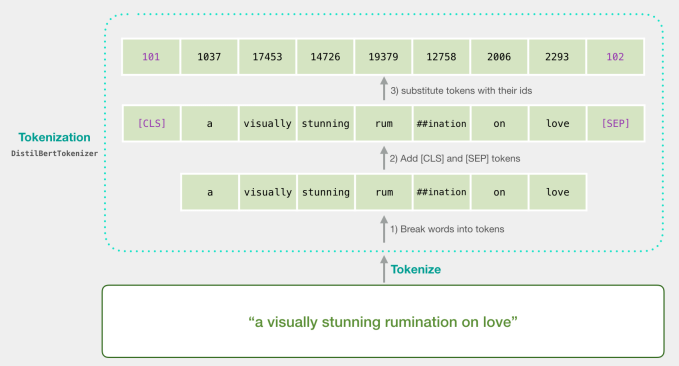


### attention_mask

* [Attention mask](https://huggingface.co/transformers/glossary.html#attention-mask)

> This argument indicates to the model which tokens should be attended to, and which should not.

If the attention_mask is ```0```, the token id is ignored. For instance if a sequence is padded to adjust the sequence length, the padded words should be ignored hence its attention_mask is 0.


In [24]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize(sentences, padding='max_length'):
    """Tokenize using the Huggingface tokenizer
    Args: 
        sentences: String or list of string to tokenize
        padding: Padding method ['do_not_pad'|'longest'|'max_length']
    """
    return tokenizer(
        sentences,
        truncation=True,
        padding=padding,
        max_length=MAX_SEQUENCE_LENGTH,
        return_tensors="tf"
    )

def decode(tokens):
    return tokenizer.decode(tokens)

When tokenized, ```i say hello``` (length 3) is padded with a special token ```[PAD]``` to match ```you say good bye``` (length 4). Hence the ```atttention_mask``` for ```i say hello``` has ```0``` at the end as in ```[1, 1, 1, 1, 1, 0]```.

In [25]:
sample_tokens = tokenize(
    [   # Two example seenteces
        "i say hello", 
        "you say good bye",
    ],
    padding='longest'
)
print(f"generatred {type(sample_tokens)} with content:\n{sample_tokens}")


generatred <class 'transformers.tokenization_utils_base.BatchEncoding'> with content:
{'input_ids': <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 101, 1045, 2360, 7592,  102,    0],
       [ 101, 2017, 2360, 2204, 9061,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [26]:
for sequence in sample_tokens['input_ids']:
    print(decode(sequence))

[CLS] i say hello [SEP] [PAD]
[CLS] you say good bye [SEP]


### Special Tokens

[BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer) addes special tokens, hence enclose dwith ```[CLS]``` and ```[SEP]```. Espacially beware of the ```[CLS]``` that represents **Classification**. ```[SEP]``` token seprates each sequence. For Question Answer or Paraphrase tasks, ```[SEP]``` seprates the two sentences to compare.

* cls_token (str, optional, defaults to "**[CLS]**")<BR>The **Classifier Token which is used when doing sequence classification** (classification of the whole sequence instead of per-token classification). It is the first token of the sequence when built with special tokens.
* sep_token (str, optional, defaults to "[SEP]")<BR>The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences for sequence classification or for a text and a question for question answering. It is also used as the last token of a sequence built with special tokens.
* unk_token (str, optional, defaults to "[UNK]")<BR>The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this token instead.
* pad_token (str, optional, defaults to "[PAD]")<BR>The token used for padding, for example when batching sequences of different lengths.
* mask_token (str, optional, defaults to "[MASK]")<BR>The token used for masking values. This is the token used when training this model with masked language modeling. This is the token which the model will try to predict.

# Base Pretrained Model - TFDistilBertModel

* [Hugging Face Transformers: Fine-tuning DistilBERT for Binary Classification Tasks](https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379)

> TFDistilBertModel class to instantiate the base DistilBERT model **without any specific head on top** (as opposed to other classes such as TFDistilBertForSequenceClassification that do have an added classification head). <br><br>
We do not want any task-specific head attached because we simply want the pre-trained weights of the base model to provide a general understanding of the English language, and it will be our job to add our own classification head during the fine-tuning process in order to help the model distinguish between toxic comments.

* HuggingFace Document [TFDistilBertModel](https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertmodel)

```
from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
outputs = model(inputs)

last_hidden_states = outputs.last_hidden_state
```



In [27]:
model_name = 'distilbert-base-uncased'
max_sequence_length = MAX_SEQUENCE_LENGTH
num_labels = NUM_LABELS

from transformers import TFDistilBertModel
# Use TFDistilBertModel as TFDistilBertForSequenceClassification has classification heads added.
# base = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
base = TFDistilBertModel.from_pretrained(
    model_name,
    num_labels=num_labels
)

# Freeze the base model weights.
for layer in base.layers:
    layer.trainable = False
base.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
Total params: 66,362,880
Trainable params: 0
Non-trainable params: 66,362,880
_________________________________________________________________


In [28]:
# Cannot get the output_shape of the pretrained model with the error.
# AttributeError: The layer has never been called and thus has no defined output shape.
# https://stackoverflow.com/questions/68234881
#for layer in base.layers:
#    print(layer.output_shape)

## Output of TFDistilBertModel

TFDistilBertModel generates TFBaseModelOutput whose ```last_hidden_state``` provides the output from the last layer of the model.
```
TFBaseModelOutput([(
    'last_hidden_state',
    <tf.Tensor: shape=(batch_size, sequence_lendgth, 768), dtype=float32, numpy=array([[[...]]], dtype=float32)>
)])
```
* [TFBaseModelOutput](https://huggingface.co/transformers/main_classes/output.html#tfbasemodeloutput)

> Parameters<br>
> * last_hidden_state (tf.Tensor of shape (batch_size, sequence_length, hidden_size)) – Sequence of hidden-states at the output of the last layer of the model.


In [29]:
base_model_output = base(sample_tokens)
#tf.print(base_model_output, summarize=1)
print(base_model_output)

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(2, 6, 768), dtype=float32, numpy=
array([[[-0.08046133, -0.05070579,  0.1651147 , ...,  0.02624892,
          0.32072204,  0.29028514],
        [ 0.38065848,  0.14633185,  0.3267992 , ..., -0.03747671,
          0.6750764 ,  0.26754215],
        [-0.13755882,  0.23116153,  0.9399943 , ..., -0.41900095,
          0.03066484,  0.14690897],
        [-0.46870404, -0.15961112,  0.70648706, ...,  0.09092106,
          0.00915723, -0.02296957],
        [ 0.94867086,  0.28354204, -0.34940276, ...,  0.22489342,
         -0.41922665, -0.44231772],
        [ 0.11706752,  0.02730656,  0.3641451 , ...,  0.2298435 ,
          0.05139099,  0.08807832]],

       [[-0.1367105 , -0.07976645,  0.13336909, ..., -0.09188621,
          0.1812089 ,  0.14311393],
        [-0.18604952,  0.00228948,  0.8748207 , ...,  0.25758246,
          0.5174806 ,  0.0779748 ],
        [ 0.04087279,  0.11673998,  1.1603655 , ..., -0.40428683,
          0.04986672,  0.20

The numerical matrix of the output can be acquired with ```last_hidden_state``` property or the indexing ```[0]``` as the root class ModelOutput provides ```__getitems``` method for indexing.

* [ModelOutput](https://huggingface.co/transformers/main_classes/output.html#modeloutput) 
> Base class for all model outputs as dataclass. Has a __getitem__ that allows indexing by integer or slice (like a tuple) or strings (like a dictionary) that will ignore the None attributes. Otherwise behaves like a regular python dictionary.

In [30]:
print(base_model_output.last_hidden_state)

tf.Tensor(
[[[-0.08046133 -0.05070579  0.1651147  ...  0.02624892  0.32072204
    0.29028514]
  [ 0.38065848  0.14633185  0.3267992  ... -0.03747671  0.6750764
    0.26754215]
  [-0.13755882  0.23116153  0.9399943  ... -0.41900095  0.03066484
    0.14690897]
  [-0.46870404 -0.15961112  0.70648706 ...  0.09092106  0.00915723
   -0.02296957]
  [ 0.94867086  0.28354204 -0.34940276 ...  0.22489342 -0.41922665
   -0.44231772]
  [ 0.11706752  0.02730656  0.3641451  ...  0.2298435   0.05139099
    0.08807832]]

 [[-0.1367105  -0.07976645  0.13336909 ... -0.09188621  0.1812089
    0.14311393]
  [-0.18604952  0.00228948  0.8748207  ...  0.25758246  0.5174806
    0.0779748 ]
  [ 0.04087279  0.11673998  1.1603655  ... -0.40428683  0.04986672
    0.20140135]
  [ 0.49050564  0.17764212  1.6637998  ... -0.2695244  -0.14997071
   -0.04277857]
  [ 0.90368307 -0.19236277  1.0621326  ...  0.18384309 -0.4522894
    0.02702072]
  [ 0.9119451   0.19694921 -0.34033242 ...  0.13686898 -0.4853739
   -0.411671

In [31]:
print(base_model_output[0])

tf.Tensor(
[[[-0.08046133 -0.05070579  0.1651147  ...  0.02624892  0.32072204
    0.29028514]
  [ 0.38065848  0.14633185  0.3267992  ... -0.03747671  0.6750764
    0.26754215]
  [-0.13755882  0.23116153  0.9399943  ... -0.41900095  0.03066484
    0.14690897]
  [-0.46870404 -0.15961112  0.70648706 ...  0.09092106  0.00915723
   -0.02296957]
  [ 0.94867086  0.28354204 -0.34940276 ...  0.22489342 -0.41922665
   -0.44231772]
  [ 0.11706752  0.02730656  0.3641451  ...  0.2298435   0.05139099
    0.08807832]]

 [[-0.1367105  -0.07976645  0.13336909 ... -0.09188621  0.1812089
    0.14311393]
  [-0.18604952  0.00228948  0.8748207  ...  0.25758246  0.5174806
    0.0779748 ]
  [ 0.04087279  0.11673998  1.1603655  ... -0.40428683  0.04986672
    0.20140135]
  [ 0.49050564  0.17764212  1.6637998  ... -0.2695244  -0.14997071
   -0.04277857]
  [ 0.90368307 -0.19236277  1.0621326  ...  0.18384309 -0.4522894
    0.02702072]
  [ 0.9119451   0.19694921 -0.34033242 ...  0.13686898 -0.4853739
   -0.411671

### Shape
For BERT, each token is embedded into a vector of size **768**. 

```(batch_size, max_sequence_length, embedding_vector_size=768)```.


In [32]:
NUM_BASE_MODEL_OUTPUT = base_model_output.last_hidden_state.shape[-1]
print("Base model last layer ouptput shape:(batch_size, sequence_length, num_output)={}".format(
    base_model_output.last_hidden_state.shape
))
print(f"Number of output (number of neurons) in the base model last layer {NUM_BASE_MODEL_OUTPUT}")

Base model last layer ouptput shape:(batch_size, sequence_length, num_output)=(2, 6, 768)
Number of output (number of neurons) in the base model last layer 768



### Fine Tuning

The embedding vector for **```[CLS]```** represents the classification that has been learned by the base model. Hence feed the embedding vector for **```[CLS]```** token the classifiation head that you add on top of the base model.

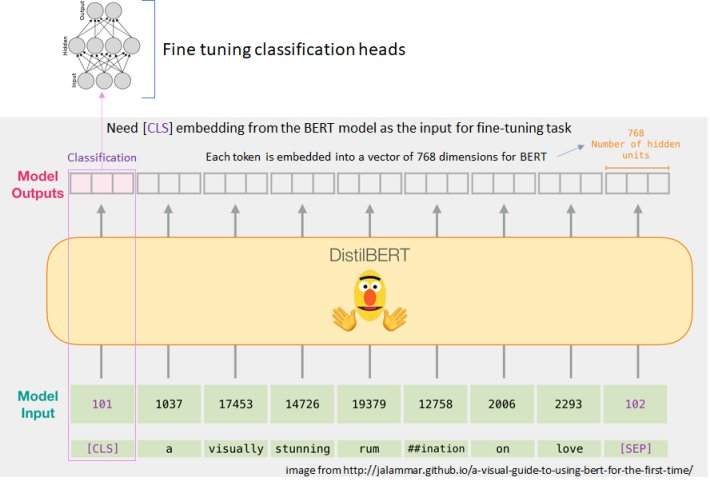


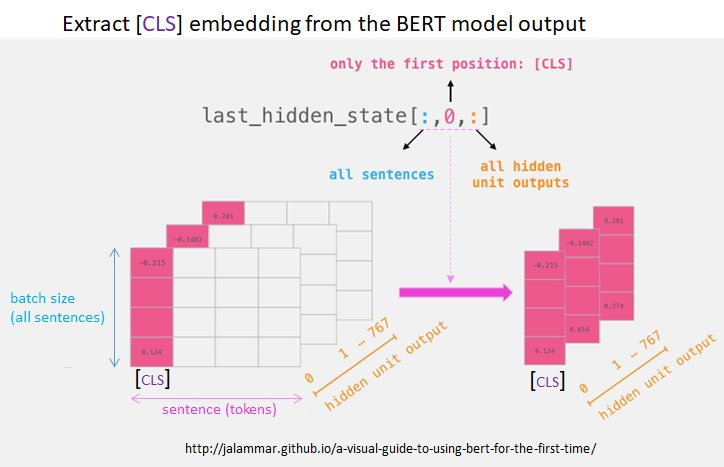


---
# Custom Model for Fine Tuning

In [53]:
test_tokens = tokenize([
    "i am a cat who has no name.",
    "to be or not to be."
])
TEST_BATCH_SIZE = len(test_tokens)

## Input layers

The base model expects ```input_ids``` and ```attention_mask``` whose shape is ```(max_sequence_length,)```. Generate Keras Tensors for them with ```Input``` layer respectively and generate the output from the base model. The base model generates ```TFBaseModelOutput```. Feed the embedding of **```[CLS]```** to the next layer.

In [54]:
# Inputs for token indices and attention masks
input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input((max_sequence_length,), dtype=tf.int32, name='attention_mask')

# TFBaseModelOutput.last_hidden_state can be acquired with [0]
# [CLS] embedding is last_hidden_state[:, 0, :]
output = base([input_ids, attention_mask]).last_hidden_state[:, 0, :]

In [55]:
# model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output, name="base_cls")
# model.summary()
# Test the model input/output
# assert model(test_tokens).shape == (TEST_BATCH_SIZE, NUM_BASE_MODEL_OUTPUT)

## Classification layers

In [56]:
# --------------------------------------------------------------------------------
# Classifiation leayer 01
# --------------------------------------------------------------------------------
output = tf.keras.layers.Dropout(
    rate=0.15,
    name="dropout",
)(output)

output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT,
    kernel_initializer='glorot_uniform',
    activation=None,
    name="classification_01",
)(output)
output = tf.keras.layers.BatchNormalization(
    name="bn_01"
)(output)
output = tf.keras.layers.Activation(
    "relu",
    name="relu_01"
)(output)

# --------------------------------------------------------------------------------
# Classifiation leayer 02
# --------------------------------------------------------------------------------
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT // 2,
    kernel_initializer='glorot_uniform',
    kernel_regularizer=tf.keras.regularizers.l2(l2=L2),
    activation=None,
    name="classification_02",
)(output)
output = tf.keras.layers.BatchNormalization(
    name="bn_02"
)(output)
output = tf.keras.layers.Activation(
    "relu",
    name="relu_02"
)(output)

## Softmax Layer


In [57]:
output = tf.keras.layers.Dense(
    units=NUM_LABELS,
    kernel_initializer='glorot_uniform',
    kernel_regularizer=tf.keras.regularizers.l2(l2=L2),
    activation='softmax',
    name="softmax"
)(output)

## Build the model

In [58]:
model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)
assert model(test_tokens).shape == (TEST_BATCH_SIZE, NUM_LABELS)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 768)          0           tf_distil_bert_model[2][0] 

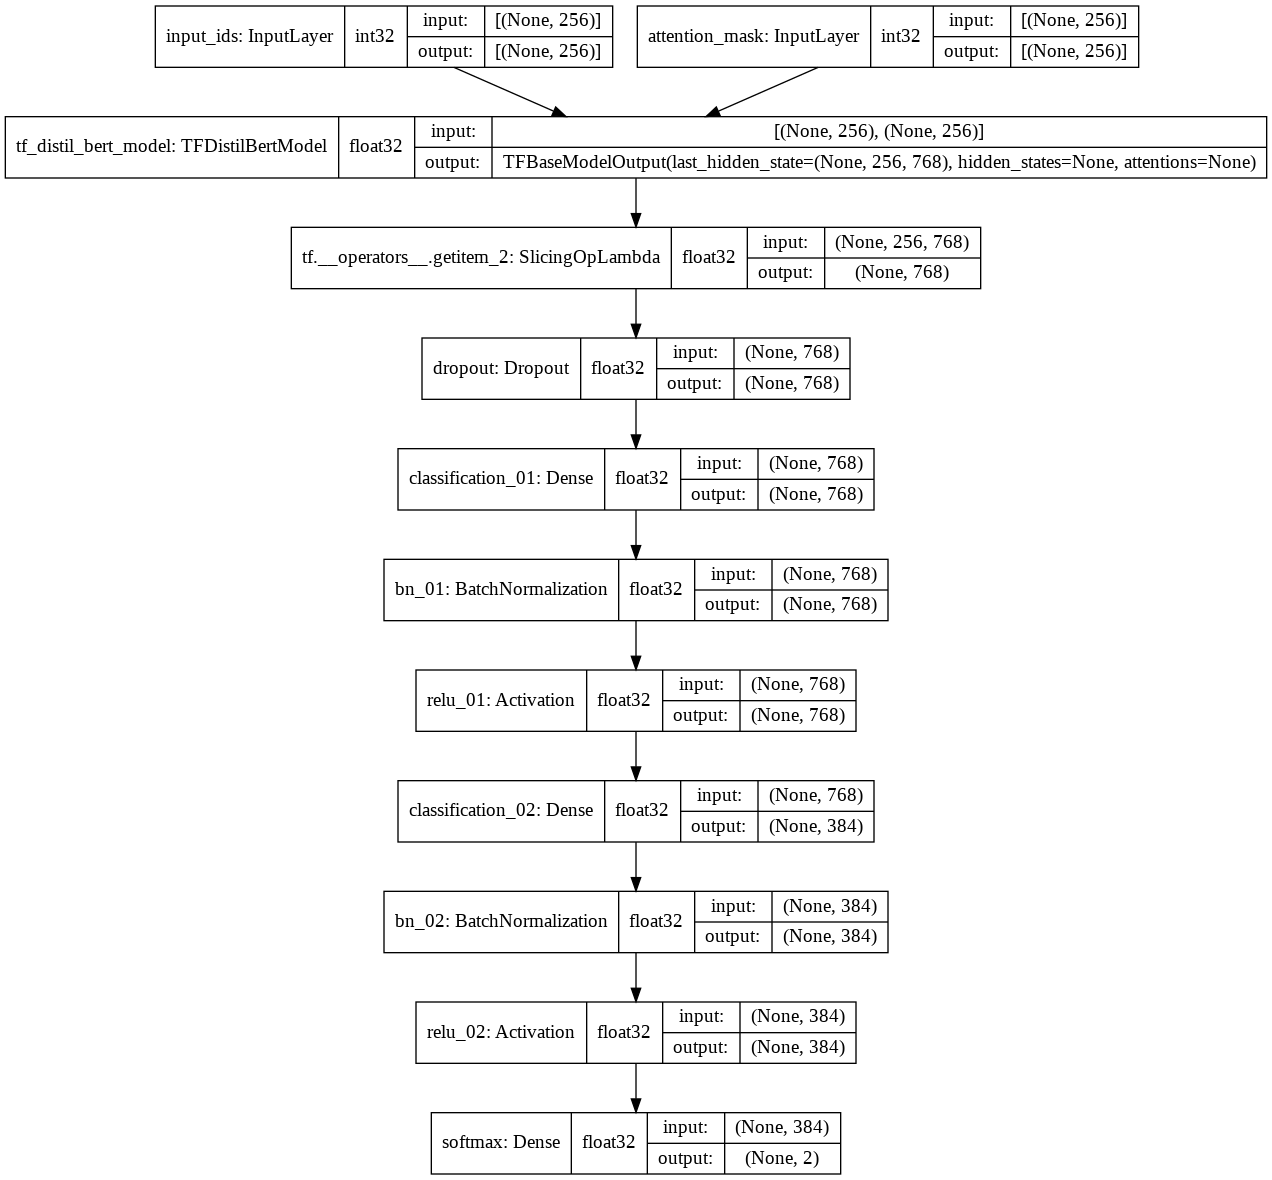

In [59]:
tf.keras.utils.plot_model(
    model, 
    show_shapes=True, 
    expand_nested=True, 
    show_dtype=True
)

# Execution

In [60]:
X = dict(tokenize(train['comment_text'].tolist()))

In [61]:
Y = np.array(train['toxic'])

In [62]:
V = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(test['comment_text'].tolist())),  # Convert BatchEncoding instance to dictionary
    test['toxic'].tolist()
)).batch(BATCH_SIZE).prefetch(1)

In [63]:
V

<PrefetchDataset shapes: ({input_ids: (None, 256), attention_mask: (None, 256)}, (None,)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [64]:
# --------------------------------------------------------------------------------
# Train the model
# --------------------------------------------------------------------------------
history = model.fit(
    x=X,
    y=Y,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=V
)

Epoch 1/5
2/2 [==============================] - 5s 2s/step - loss: 1.5804 - accuracy: 0.6562 - val_loss: 1.7974 - val_accuracy: 0.5333
Epoch 2/5
2/2 [==============================] - 0s 155ms/step - loss: 1.7425 - accuracy: 0.8281 - val_loss: 0.7534 - val_accuracy: 0.9333
Epoch 3/5
2/2 [==============================] - 0s 154ms/step - loss: 0.8004 - accuracy: 0.9375 - val_loss: 1.1298 - val_accuracy: 0.9333
Epoch 4/5
2/2 [==============================] - 0s 154ms/step - loss: 0.9134 - accuracy: 0.9062 - val_loss: 1.3512 - val_accuracy: 0.9333
Epoch 5/5
2/2 [==============================] - 0s 152ms/step - loss: 0.9441 - accuracy: 0.9219 - val_loss: 1.3754 - val_accuracy: 0.9333
